# Detecção em escala aleatória de sequências do MNIST

## Importando módulos

In [1]:
import os
import pkgutil

if pkgutil.find_loader('torch') is None:
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [2]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from collections import OrderedDict

import torch
import torchvision
from torchvision.datasets import MNIST

import cv2

In [3]:
np.set_printoptions(precision=1, linewidth=120)
torch.set_printoptions(precision=1, linewidth=120)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Device:", device)

Device: cuda


## Dataset

In [5]:
dataset_dir = '../data/MNIST/processed/'
num_scales = 2
max_len = 7

In [6]:
class RandomScaleNumbersMNIST(torch.utils.data.Dataset):
    def __init__(self, processed_data_dir, length, mat_size=280, num_scales=2,
                 min_size=28, max_size=52, max_len=7, debug=False):
        num_attempts = 20

        self.length = length
        self.num_scales = num_scales

        self.reg_fields = {
            'tX': 0,
            'tY': 1
        }

        self.cls_fields = {
            'presence': 0,
            'delta_height': 1,
            'digit_class': 2,
            'digit_index': 3,
            'number_len': 4
        }

        # 28 30 32 34 36 38 40 42 44 46 48 50
        digit_size_array = np.arange(min_size, max_size, 2)
        self.digit_size_ref_delta = (max_size - min_size) / num_scales
        self.digit_size_ref = np.array([min_size + self.digit_size_ref_delta * idx for idx in range(num_scales)])

        num_cells = (mat_size / self.digit_size_ref).astype('int').tolist()
        self.cell_central_pixel = [np.arange(size_ref/2, mat_size, size_ref) for size_ref in self.digit_size_ref]
        cell_pixel_between = [(central_array[:-1] + central_array[1:]) // 2 for central_array in self.cell_central_pixel]

        if debug:
            print(f'digit_size_ref_delta: {self.digit_size_ref_delta}')
            print(f'digit_size_array: {digit_size_array}')
            print(f'digit_size_ref: {self.digit_size_ref}')
            print(f'num_cells: {num_cells}')
            print(f'cell_central_pixel: {self.cell_central_pixel}')
            print(f'cell_pixel_between: {cell_pixel_between}')
            print('\n')

        test_data, test_label = torch.load(os.path.join(processed_data_dir, 'test.pt'))
        train_data, train_label = torch.load(os.path.join(processed_data_dir, 'training.pt'))

        self.joint_data = torch.cat((train_data, test_data), dim=0).type(torch.FloatTensor) / 255.0
        self.joint_label = torch.cat((train_label, test_label), dim=0)

        data_idx_array = np.arange(self.joint_data.shape[0])

        self.mat_image = torch.zeros((self.length, 1, mat_size, mat_size), dtype=torch.float)
        self.mat_label_reg = list()
        self.mat_label_cls = list()
        for entry in num_cells:
            self.mat_label_reg.append(torch.zeros((self.length, len(self.reg_fields), entry, entry), dtype=torch.float))
            self.mat_label_cls.append(torch.zeros((self.length, len(self.cls_fields), entry, entry), dtype=torch.long))
            self.mat_label_cls[-1][:, self.cls_fields['delta_height']:self.cls_fields['number_len']] = -1
            #self.mat_label_cls[-1][:, self.cls_fields['delta_height']:] = -1

        for sample_idx in range(self.length):
            frame_list = list()

            num_numbers = np.random.randint(5, 15)
            for data_idx in range(num_numbers):
                # Choose digit size among options and get closest size reference
                digit_size = np.random.choice(digit_size_array)
                digit_size_diff = digit_size - self.digit_size_ref

                digit_size_ref_idx = np.argmin(np.abs(digit_size_diff))
                if digit_size_diff[digit_size_ref_idx] < 0:
                    digit_size_ref_idx -= 1

                digit_size_delta = digit_size_diff[digit_size_ref_idx]

                # Get number_len that fits based on digit_size
                len_upper_limit = int(np.minimum(np.floor(mat_size / digit_size), max_len))

                number_len = np.random.randint(1, len_upper_limit)
                number_size = digit_size * number_len

                digit_attempt = 0
                while digit_attempt != num_attempts:
                    nx1 = np.random.randint(0, mat_size-number_size)
                    ny1 = np.random.randint(0, mat_size-digit_size)
                    nx2, ny2 = nx1+number_size, ny1+digit_size

                    frame_idx = 0
                    while frame_idx != len(frame_list):
                        frame_x1, frame_y1, frame_x2, frame_y2 = frame_list[frame_idx]

                        nx1_between = (nx1 >= frame_x1) and (nx1 < frame_x2)
                        nx2_between = (nx2 >= frame_x1) and (nx2 < frame_x2)

                        ny1_between = (ny1 >= frame_y1) and (ny1 < frame_y2)
                        ny2_between = (ny2 >= frame_y1) and (ny2 < frame_y2)

                        frame_x1_between = (frame_x1 >= nx1) and (frame_x1 < nx2)
                        frame_x2_between = (frame_x2 >= nx1) and (frame_x2 < nx2)

                        frame_y1_between = (frame_y1 >= ny1) and (frame_y1 < ny2)
                        frame_y2_between = (frame_y2 >= ny1) and (frame_y2 < ny2)

                        x_between = nx1_between or nx2_between or frame_x1_between or frame_x2_between
                        y_between = ny1_between or ny2_between or frame_y1_between or frame_y2_between

                        if x_between and y_between:
                            break
                        else:
                            frame_idx += 1

                    if frame_idx == len(frame_list):
                        frame_list.append([nx1, ny1, nx2, ny2])
                        break
                    else:
                        digit_attempt += 1

                if digit_attempt != num_attempts:
                    np.random.shuffle(data_idx_array)

                    y_centroid = ny1 + (digit_size // 2)
                    y_centroid_diff = cell_pixel_between[digit_size_ref_idx] - y_centroid
                    y_closest_pixel = np.argmin(np.abs(y_centroid_diff))
                    y_central_pixel_idx = y_closest_pixel if y_centroid_diff[y_closest_pixel] >= 0 else y_closest_pixel + 1
                    y_central_pixel = self.cell_central_pixel[digit_size_ref_idx][y_central_pixel_idx]
                    ty = cell_pixel_between[digit_size_ref_idx][y_closest_pixel] - y_centroid_diff[y_closest_pixel] - y_central_pixel

                    dx1 = nx1
                    dx2 = dx1 + digit_size
                    for digit_index in range(number_len):
                        digit_idx = data_idx_array[digit_index]

                        digit_array = cv2.resize(self.joint_data[digit_idx].numpy(), dsize=(digit_size, digit_size))
                        self.mat_image[sample_idx, 0, ny1:ny2, dx1:dx2] = torch.from_numpy(digit_array)

                        # Compute distance of digit centroid to each cell interface to pick the right cell and tx/ty
                        x_centroid = dx1 + (digit_size // 2)
                        x_centroid_diff = cell_pixel_between[digit_size_ref_idx] - x_centroid
                        x_closest_pixel = np.argmin(np.abs(x_centroid_diff))
                        x_central_pixel_idx = x_closest_pixel if x_centroid_diff[x_closest_pixel] >= 0 else x_closest_pixel + 1
                        x_central_pixel = self.cell_central_pixel[digit_size_ref_idx][x_central_pixel_idx]
                        tx = cell_pixel_between[digit_size_ref_idx][x_closest_pixel] - x_centroid_diff[x_closest_pixel] - x_central_pixel

                        self.mat_label_reg[digit_size_ref_idx][sample_idx, self.reg_fields['tX'],
                                                               y_central_pixel_idx, x_central_pixel_idx] = tx
                        self.mat_label_reg[digit_size_ref_idx][sample_idx, self.reg_fields['tY'],
                                                               y_central_pixel_idx, x_central_pixel_idx] = ty

                        self.mat_label_cls[digit_size_ref_idx][sample_idx, self.cls_fields['presence'],
                                                               y_central_pixel_idx, x_central_pixel_idx] = 1
                        self.mat_label_cls[digit_size_ref_idx][sample_idx, self.cls_fields['delta_height'],
                                                               y_central_pixel_idx, x_central_pixel_idx] = digit_size_delta // 2
                        self.mat_label_cls[digit_size_ref_idx][sample_idx, self.cls_fields['digit_class'],
                                                               y_central_pixel_idx, x_central_pixel_idx] = self.joint_label[digit_idx]
                        self.mat_label_cls[digit_size_ref_idx][sample_idx, self.cls_fields['digit_index'],
                                                               y_central_pixel_idx, x_central_pixel_idx] = digit_index
                        self.mat_label_cls[digit_size_ref_idx][sample_idx, self.cls_fields['number_len'],
                                                               y_central_pixel_idx, x_central_pixel_idx] = number_len

                        dx1 += digit_size
                        dx2 += digit_size

        if not debug:
            for idx in range(len(self.mat_label_reg)):
                self.mat_label_reg[idx] /= self.digit_size_ref[idx] / 2
                self.mat_label_cls[idx][:, self.cls_fields['number_len']] -= 1

    def getFields(self):
        fields_dict = {
            'reg': self.reg_fields,
            'cls': self.cls_fields
        }

        return fields_dict

    def getDigitSize(self):
        return self.digit_size_ref

    def getDigitSizeRefDelta(self):
        return self.digit_size_ref_delta

    def getCellCentralRef(self):
        return self.cell_central_pixel

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        label_reg = list()
        label_cls = list()

        for scale in range(self.num_scales):
            label_reg.append(self.mat_label_reg[scale][index])
            label_cls.append(self.mat_label_cls[scale][index])

        return self.mat_image[index], label_reg, label_cls

### Visualização de exemplo

In [7]:
def printSample(dataset, idx, fields_dict):
    image, label_reg_list, label_cls_list = dataset[idx]

    for scale_idx in range(num_scales):
        print(f'\nScale {scale_idx}')
        for key in fields_dict['reg']:
            print(f'{key}:\n{label_reg_list[scale_idx][fields_dict["reg"][key]]}\n')
        for key in fields_dict['cls']:
            print(f'{key}:\n{label_cls_list[scale_idx][fields_dict["cls"][key]]}\n')

def vizSample(dataset, idx, fields_dict, digit_size_array, digit_central_ref_array):
    text_fontsize = 14

    image, label_reg_list, label_cls_list = dataset[idx]

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(image[0].numpy(), cmap='Greys')
    ax.grid(False)
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')

    digit_info = list()
    digit_idx = 0
    number_class = ''

    for scale_idx in range(num_scales):
        digit_central_ref = digit_central_ref_array[scale_idx]

        label_reg = label_reg_list[scale_idx]
        label_cls = label_cls_list[scale_idx]

        digit_size_mat = digit_size_array[scale_idx] + (label_cls[fields_dict['cls']['delta_height']] * 2)

        digit_coord_array = label_cls[fields_dict['cls']['presence']].nonzero()
        for digit_coord in digit_coord_array:
            digit_info_dict = {
                'idx': digit_idx
            }

            digit_coord_y = digit_coord[0].item()
            digit_coord_x = digit_coord[1].item()

            for key in fields_dict['reg']:
                digit_info_dict[key] = label_reg[fields_dict['reg'][key]][digit_coord_y, digit_coord_x].item()
            for key in fields_dict['cls']:
                digit_info_dict[key] = label_cls[fields_dict['cls'][key]][digit_coord_y, digit_coord_x].item()

            digit_info_dict['digit_size'] = int(digit_size_mat[digit_coord_y, digit_coord_x].item())
            delta_size = digit_info_dict['digit_size'] / 2

            digit_x = (digit_central_ref[digit_coord_x] + digit_info_dict['tX']) - delta_size
            digit_y = (digit_central_ref[digit_coord_y] + digit_info_dict['tY']) - delta_size

            ax.add_patch(patches.Rectangle([digit_x, digit_y],
                                           digit_info_dict['digit_size'],
                                           digit_info_dict['digit_size'],
                                           fill=False, edgecolor='green', lw=2))
            ax.text(digit_x, digit_y+(text_fontsize), str(digit_idx), fontsize=text_fontsize)

            digit_idx += 1

            if digit_info_dict['digit_index'] == 0:
                number_class = str(digit_info_dict['digit_class'])
            else:
                number_class += str(digit_info_dict['digit_class'])

            if digit_info_dict['digit_index'] == digit_info_dict['number_len'] - 1:
                digit_info_dict['number_size'] = digit_info_dict['number_len'] * digit_info_dict['digit_size']

                digit_0_x = digit_x + digit_info_dict['digit_size'] - digit_info_dict['number_size']

                digit_info_dict['frame'] = [digit_0_x, digit_y,
                                            digit_0_x+digit_info_dict['number_size'],
                                            digit_y+digit_info_dict['digit_size']]

                ax.add_patch(patches.Rectangle([digit_0_x, digit_y],
                                               digit_info_dict['number_size'],
                                               digit_info_dict['digit_size'],
                                               fill=False, edgecolor='blue', lw=2))
                ax.text(digit_0_x, digit_y+(text_fontsize//2), str(number_class), fontsize=text_fontsize)

            digit_info.append(digit_info_dict)

    key_list = ['idx', 'digit_class', 'digit_size', 'tX', 'tY', 'digit_index', 'number_len']
    #key_list = ['idx', 'digit_class', 'digit_size', 'tX', 'tY', 'digit_index']

    for idx in range(digit_idx):
        digit_str_list = list()

        for key in key_list:
            digit_str_list.append(f'{key}:{digit_info[idx][key]}')

        digit_str = f'Digit ' + ' | '.join(digit_str_list)
        print(digit_str)

    #plt.axis('off')
    plt.show()

In [8]:
mnist_dataset = RandomScaleNumbersMNIST(dataset_dir, 1, num_scales=num_scales, max_len=max_len, debug=True)

fields_dict = mnist_dataset.getFields()
digit_size_array = mnist_dataset.getDigitSize()
digit_size_ref_delta = mnist_dataset.getDigitSizeRefDelta()
digit_central_ref_array = mnist_dataset.getCellCentralRef()

digit_size_ref_delta: 12.0
digit_size_array: [28 30 32 34 36 38 40 42 44 46 48 50]
digit_size_ref: [28. 40.]
num_cells: [10, 7]
cell_central_pixel: [array([ 14.,  42.,  70.,  98., 126., 154., 182., 210., 238., 266.]), array([ 20.,  60., 100., 140., 180., 220., 260.])]
cell_pixel_between: [array([ 28.,  56.,  84., 112., 140., 168., 196., 224., 252.]), array([ 40.,  80., 120., 160., 200., 240.])]




Digit idx:0 | digit_class:4 | digit_size:28 | tX:-3.0 | tY:3.0 | digit_index:0 | number_len:6
Digit idx:1 | digit_class:4 | digit_size:28 | tX:-3.0 | tY:3.0 | digit_index:1 | number_len:6
Digit idx:2 | digit_class:7 | digit_size:28 | tX:-3.0 | tY:3.0 | digit_index:2 | number_len:6
Digit idx:3 | digit_class:6 | digit_size:28 | tX:-3.0 | tY:3.0 | digit_index:3 | number_len:6
Digit idx:4 | digit_class:7 | digit_size:28 | tX:-3.0 | tY:3.0 | digit_index:4 | number_len:6
Digit idx:5 | digit_class:6 | digit_size:28 | tX:-3.0 | tY:3.0 | digit_index:5 | number_len:6
Digit idx:6 | digit_class:0 | digit_size:30 | tX:8.0 | tY:6.0 | digit_index:0 | number_len:1
Digit idx:7 | digit_class:5 | digit_size:28 | tX:7.0 | tY:13.0 | digit_index:0 | number_len:4
Digit idx:8 | digit_class:3 | digit_size:28 | tX:7.0 | tY:13.0 | digit_index:1 | number_len:4
Digit idx:9 | digit_class:3 | digit_size:28 | tX:7.0 | tY:13.0 | digit_index:2 | number_len:4
Digit idx:10 | digit_class:8 | digit_size:28 | tX:7.0 | tY:13

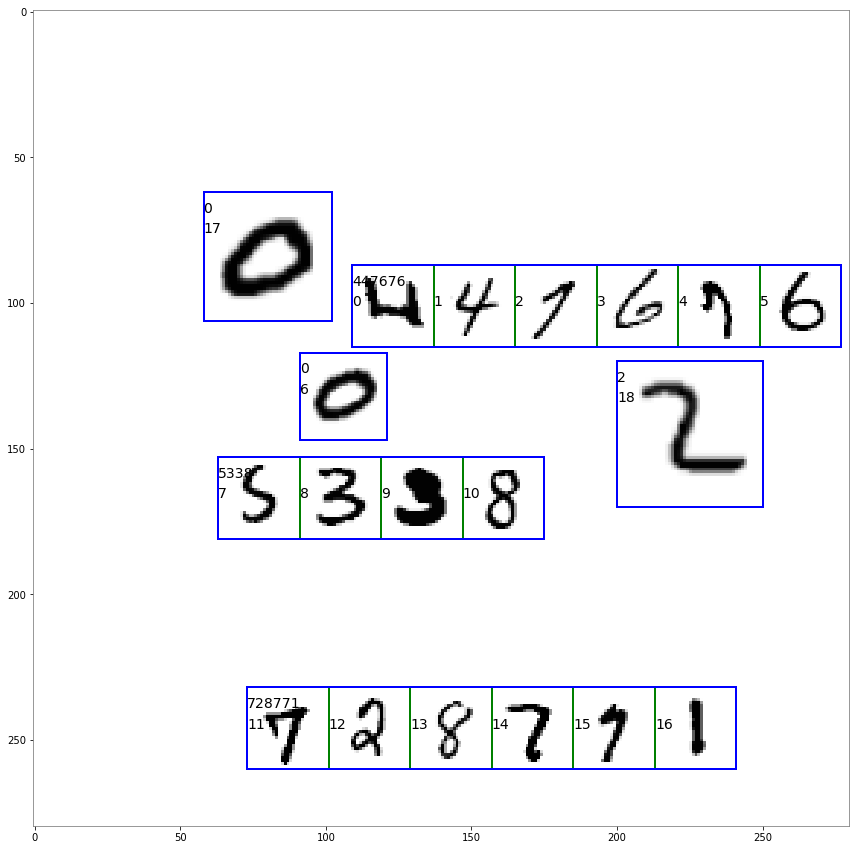

In [9]:
vizSample(mnist_dataset, 0, fields_dict, digit_size_array, digit_central_ref_array)

In [10]:
printSample(mnist_dataset, 0, fields_dict)


Scale 0
tX:
tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  -3.,  -3.,  -3.,  -3.,  -3.,  -3.],
        [  0.,   0.,   0.,   8.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   7.,   7.,   7.,   7.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0., -11., -11., -11., -11., -11., -11.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

tY:
tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,  3.],
        [ 0.,  0.,  0.,  6.,  0.,  0.,  0

### Criação dos datasets de Treinamento, Validação e Teste

In [11]:
num_samples_train = 6000
num_samples_valid = 1200
num_samples_test = 600

dataset_train = RandomScaleNumbersMNIST(dataset_dir, num_samples_train, num_scales=num_scales)
dataset_valid = RandomScaleNumbersMNIST(dataset_dir, num_samples_valid, num_scales=num_scales)
dataset_test = RandomScaleNumbersMNIST(dataset_dir, num_samples_test, num_scales=num_scales)

## Dataloaders

In [12]:
batch_size = 12

dataloaders = {
    'train': torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0),
    'valid': torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=0)
}

## Modelo de Rede Neural

In [13]:
field_depth = OrderedDict([
    ('reg', 2),
    ('presence', 2),
    ('delta_height', int(digit_size_ref_delta // 2)),
    ('digit_class', 10),
    ('digit_index', max_len - 1),
    ('number_len', max_len - 1)
])

label_depth = sum(field_depth.values())

In [14]:
class DownConv(torch.nn.Module):
    """
    Based on https://www.kaggle.com/witwitchayakarn/u-net-with-pytorch
    """
    def __init__(self, in_channels, out_channels):
        super(DownConv, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.af = torch.nn.LeakyReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.af(x)
        x = self.conv2(x)
        x = self.af(x)

        before_pool = x
        x = self.pool(x)

        return x, before_pool

class UpConv(torch.nn.Module):
    """
    Based on https://www.kaggle.com/witwitchayakarn/u-net-with-pytorch
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 merge_mode='concat',
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        self.upconv = torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = torch.nn.Conv2d(in_channels=2*out_channels, out_channels=out_channels, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3)
        self.af = torch.nn.LeakyReLU()

    def forward(self, from_down, from_up):
        """ Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        from_up = self.upconv(from_up)
        x = torch.cat((from_up, from_down), 1)
        x = self.conv1(x)
        x = self.af(x)
        x = self.conv2(x)
        x = self.af(x)

        return x

class RandomScaleNumbersModel(torch.nn.Module):
    def __init__(self, label_depth):
        super(RandomScaleNumbersModel, self).__init__()

        num_feat_layers = 14
        feat_depth_array = [int(label_depth + (idx * 2)) for idx in range(num_feat_layers-1, -1, -1)]

        num_contract_layers = 5
        contract_depth_array = [int(label_depth + (idx * 4)) for idx in range(1, num_contract_layers+1)]

        num_expand_layers = 1
        expand_depth_array = contract_depth_array[-2:(-2 - num_expand_layers):-1]

        num_scale_layers = 4
        scale_depth_array = contract_depth_array[(-2 - num_expand_layers):-(num_contract_layers + 1):-1] + [label_depth]

        depth_array = feat_depth_array + contract_depth_array + expand_depth_array + scale_depth_array
        print(f'Layer channels: {depth_array}')

        self.feat = torch.nn.Sequential(OrderedDict([
            # 280 > 140
            ('feat_conv_01', torch.nn.Conv2d(in_channels=1, out_channels=depth_array[0], kernel_size=3, padding=1)),
            ('feat_relu_01', torch.nn.LeakyReLU()),
            ('feat_conv_02', torch.nn.Conv2d(in_channels=depth_array[0], out_channels=depth_array[1], kernel_size=3, padding=1)),
            ('feat_relu_02', torch.nn.LeakyReLU()),
            ('feat_conv_03', torch.nn.Conv2d(in_channels=depth_array[1], out_channels=depth_array[2], kernel_size=3, padding=1)),
            ('feat_relu_03', torch.nn.LeakyReLU()),
            ('feat_maxpool_01', torch.nn.MaxPool2d(kernel_size=2)),
            # 140 > 70
            ('feat_conv_04', torch.nn.Conv2d(in_channels=depth_array[2], out_channels=depth_array[3], kernel_size=3, padding=1)),
            ('feat_relu_04', torch.nn.LeakyReLU()),
            ('feat_conv_05', torch.nn.Conv2d(in_channels=depth_array[3], out_channels=depth_array[4], kernel_size=3, padding=1)),
            ('feat_relu_05', torch.nn.LeakyReLU()),
            ('feat_conv_06', torch.nn.Conv2d(in_channels=depth_array[4], out_channels=depth_array[5], kernel_size=3, padding=1)),
            ('feat_relu_06', torch.nn.LeakyReLU()),
            ('feat_maxpool_02', torch.nn.MaxPool2d(kernel_size=2)),
            # 70 > 68
            ('feat_conv_07', torch.nn.Conv2d(in_channels=depth_array[5], out_channels=depth_array[6], kernel_size=3, padding=1)),
            ('feat_relu_07', torch.nn.LeakyReLU()),
            ('feat_conv_08', torch.nn.Conv2d(in_channels=depth_array[6], out_channels=depth_array[7], kernel_size=3)),
            ('feat_relu_08', torch.nn.LeakyReLU()),
            # 68 > 34
            ('feat_conv_09', torch.nn.Conv2d(in_channels=depth_array[7], out_channels=depth_array[8], kernel_size=3, padding=1)),
            ('feat_relu_09', torch.nn.LeakyReLU()),
            ('feat_maxpool_03', torch.nn.MaxPool2d(kernel_size=2)),
            # 34 > 32
            ('feat_conv_10', torch.nn.Conv2d(in_channels=depth_array[8], out_channels=depth_array[9], kernel_size=3, padding=1)),
            ('feat_relu_10', torch.nn.LeakyReLU()),
            ('feat_conv_11', torch.nn.Conv2d(in_channels=depth_array[9], out_channels=depth_array[10], kernel_size=3)),
            ('feat_relu_11', torch.nn.LeakyReLU()),
            # 32 > 16
            ('feat_conv_12', torch.nn.Conv2d(in_channels=depth_array[10], out_channels=depth_array[11], kernel_size=3, padding=1)),
            ('feat_relu_12', torch.nn.LeakyReLU()),
            ('feat_maxpool_04', torch.nn.MaxPool2d(kernel_size=2)),
            # 16 > 16
            ('feat_conv_13', torch.nn.Conv2d(in_channels=depth_array[11], out_channels=depth_array[12], kernel_size=3, padding=1)),
            ('feat_relu_13', torch.nn.LeakyReLU()),
            ('feat_conv_14', torch.nn.Conv2d(in_channels=depth_array[12], out_channels=depth_array[13], kernel_size=3, padding=1)),
            ('feat_relu_14', torch.nn.LeakyReLU())
        ]))

        self.ce = torch.nn.Sequential(OrderedDict([
            # 16 > 14
            ('ce_conv_01', torch.nn.Conv2d(in_channels=depth_array[13], out_channels=depth_array[14], kernel_size=3)),
            ('ce_relu_01', torch.nn.LeakyReLU()),
            # 14 > 12
            ('ce_conv_02', torch.nn.Conv2d(in_channels=depth_array[14], out_channels=depth_array[15], kernel_size=3)),
            ('ce_relu_02', torch.nn.LeakyReLU()),
            # 12 > 10
            ('ce_conv_03', torch.nn.Conv2d(in_channels=depth_array[15], out_channels=depth_array[16], kernel_size=3)),
            ('ce_relu_03', torch.nn.LeakyReLU()),
            # 10 > 7
            ('ce_conv_04', torch.nn.Conv2d(in_channels=depth_array[16], out_channels=depth_array[17], kernel_size=4)),
            ('ce_relu_04', torch.nn.LeakyReLU()),
            # 7 > 5
            ('ce_conv_05', torch.nn.Conv2d(in_channels=depth_array[17], out_channels=depth_array[18], kernel_size=3)),
            ('ce_relu_05', torch.nn.LeakyReLU()),
            # 5 > 7
            ('ce_transp_01', torch.nn.ConvTranspose2d(in_channels=depth_array[18], out_channels=depth_array[19], kernel_size=3)),
            ('ce_relu_06', torch.nn.LeakyReLU())
        ]))

        self.scale_0 = torch.nn.Sequential(OrderedDict([
            # 10 (28 > 32)
            ('s0_transp_01', torch.nn.ConvTranspose2d(in_channels=depth_array[19], out_channels=depth_array[20], kernel_size=4)),
            ('s0_relu_01', torch.nn.LeakyReLU()),
            ('s0_conv_02', torch.nn.Conv2d(in_channels=depth_array[20], out_channels=depth_array[21], kernel_size=3, padding=1)),
            ('s0_relu_02', torch.nn.LeakyReLU()),
            ('s0_conv_03', torch.nn.Conv2d(in_channels=depth_array[21], out_channels=depth_array[22], kernel_size=3, padding=1)),
            ('s0_relu_03', torch.nn.LeakyReLU()),
            ('s0_conv_04', torch.nn.Conv2d(in_channels=depth_array[22], out_channels=depth_array[23], kernel_size=3, padding=1))
        ]))

        self.scale_1 = torch.nn.Sequential(OrderedDict([
            # 7 (28 > 32)
            ('s1_conv_01', torch.nn.Conv2d(in_channels=depth_array[19], out_channels=depth_array[20], kernel_size=3, padding=1)),
            ('s1_relu_01', torch.nn.LeakyReLU()),
            ('s1_conv_02', torch.nn.Conv2d(in_channels=depth_array[20], out_channels=depth_array[21], kernel_size=3, padding=1)),
            ('s1_relu_02', torch.nn.LeakyReLU()),
            ('s1_conv_03', torch.nn.Conv2d(in_channels=depth_array[21], out_channels=depth_array[22], kernel_size=3, padding=1)),
            ('s1_relu_03', torch.nn.LeakyReLU()),
            ('s1_conv_04', torch.nn.Conv2d(in_channels=depth_array[22], out_channels=depth_array[23], kernel_size=3, padding=1))
        ]))

    def forward(self, x):
        f = self.feat(x)
        fce = self.ce(f)
        y0 = self.scale_0(fce)
        y1 = self.scale_1(fce)

        return [y0, y1]

## Função de perda customizada

In [15]:
ordered_fields = list(field_depth.keys())
first_field = ordered_fields[0]

field_range = {
    'start': {
        first_field: 0
    },
    'end': {
        first_field: field_depth[first_field]
    }
}

for key_idx in range(1, len(ordered_fields)):
    prev_key = ordered_fields[key_idx - 1]
    cur_key = ordered_fields[key_idx]

    field_range['start'][cur_key] = field_range['end'][prev_key]
    field_range['end'][cur_key] = field_range['start'][cur_key] + field_depth[cur_key]

In [16]:
class RandomScaleNumbersLoss(torch.nn.Module):
    def __init__(self, ordered_fields, fields_dict, field_range, num_scales):
        super().__init__()
        self.ordered_fields = ordered_fields
        self.fields_dict = fields_dict
        self.field_range = field_range
        self.num_scales = num_scales

        presence_weights = torch.tensor([0.1, 1]).to(device)
        self.cel = {
            'presence': torch.nn.CrossEntropyLoss(weight=presence_weights)
        }
        for key in self.ordered_fields[2:]:
            self.cel[key] = torch.nn.CrossEntropyLoss(ignore_index=-1)

    def customMSELoss(self, predict, target, mask):
        num_elem = torch.sum(mask, (3, 2, 1))
        num_elem[num_elem == 0] = 1
        mse_loss_calc_1 = (predict - target) ** 2
        mse_loss_calc_2 = torch.sum(mse_loss_calc_1 * mask, (3, 2, 1)) / num_elem
        return torch.sum(mse_loss_calc_2) / len(mse_loss_calc_2)

    def forward(self, predict_list, target_reg_list, target_cls_list, debug=False):
        loss_dict = dict()
        for key in self.ordered_fields:
            loss_dict[key] = list()

        for scale_idx in range(self.num_scales):
            predict_scale = predict_list[scale_idx].to(device)
            target_reg_scale = target_reg_list[scale_idx].to(device)
            target_cls_scale = target_cls_list[scale_idx].to(device)

            presence_idx = self.fields_dict['cls']['presence']
            presence_mask = target_cls_scale[:, presence_idx:(presence_idx + 1)].type(torch.float)
            loss_dict['reg'].append(self.customMSELoss(predict_scale[:, self.field_range['start']['reg']:self.field_range['end']['reg']],
                                                       target_reg_scale, presence_mask))

            for key_idx in range(1, len(self.ordered_fields)):
                key = self.ordered_fields[key_idx]
                key_index = self.fields_dict['cls'][key]
                loss_dict[key].append(self.cel[key](predict_scale[:, self.field_range['start'][key]:self.field_range['end'][key]],
                                                    target_cls_scale[:, key_index]))

        if debug:
            print('Loss:')
            for key in self.ordered_fields:
                print(f'{key}: {loss_dict[key]}')

        return sum([sum(entry) for entry in loss_dict.values()])

## Teste das etapas (dataloader, modelo e função de perda)

In [17]:
dataiter = iter(dataloaders['train'])

In [18]:
sample_images, sample_labels_reg_list, sample_labels_cls_list = dataiter.next()

print(f'Input')
print(f'    Format: {sample_images.shape}')
print(f'    Type: {sample_images.dtype}')
print(f'    Range: [{sample_images.min()}, {sample_images.max()}]')
print('\n')

print(f'Label')
for scale_idx in range(num_scales):
    print(f'    Scale {scale_idx}')
    print(f'        Regression')
    print(f'            Format: {sample_labels_reg_list[scale_idx].shape}')
    print(f'            Type: {sample_labels_reg_list[scale_idx].dtype}')
    print(f'            Range:')

    for key in fields_dict['reg']:
        key_index = fields_dict['reg'][key]
        print(f'                {key}: [{sample_labels_reg_list[scale_idx][:, key_index].min()}, {sample_labels_reg_list[scale_idx][:, key_index].max()}]')

    print(f'        Classification')
    print(f'            Format: {sample_labels_cls_list[scale_idx].shape}')
    print(f'            Type: {sample_labels_cls_list[scale_idx].dtype}')
    print(f'            Range:')

    for key in fields_dict['cls']:
        key_index = fields_dict['cls'][key]
        print(f'                {key}: [{sample_labels_cls_list[scale_idx][:, key_index].min()}, {sample_labels_cls_list[scale_idx][:, key_index].max()}]')

Input
    Format: torch.Size([12, 1, 280, 280])
    Type: torch.float32
    Range: [0.0, 1.0]


Label
    Scale 0
        Regression
            Format: torch.Size([12, 2, 10, 10])
            Type: torch.float32
            Range:
                tX: [-0.9285714030265808, 1.0]
                tY: [-0.9285714030265808, 1.0]
        Classification
            Format: torch.Size([12, 5, 10, 10])
            Type: torch.int64
            Range:
                presence: [0, 1]
                delta_height: [-1, 5]
                digit_class: [-1, 9]
                digit_index: [-1, 5]
                number_len: [-1, 5]
    Scale 1
        Regression
            Format: torch.Size([12, 2, 7, 7])
            Type: torch.float32
            Range:
                tX: [-0.949999988079071, 0.949999988079071]
                tY: [-0.949999988079071, 1.0]
        Classification
            Format: torch.Size([12, 5, 7, 7])
            Type: torch.int64
            Range:
                prese

In [19]:
random_scale_seq_model = RandomScaleNumbersModel(label_depth).to(device)
sample_images = sample_images.to(device)
output_list = random_scale_seq_model(sample_images)

print(f'Output')
for scale_idx in range(num_scales):
    print(f'    Scale {scale_idx}')
    print(f'        Format: {output_list[scale_idx].shape}')
    print(f'        Type: {output_list[scale_idx].dtype}')
    print(f'        Range: [{output_list[scale_idx].min()}, {output_list[scale_idx].max()}]')

Layer channels: [58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 36, 40, 44, 48, 52, 48, 44, 40, 36, 32]
Output
    Scale 0
        Format: torch.Size([12, 32, 10, 10])
        Type: torch.float32
        Range: [-0.06438305974006653, 0.06395961344242096]
    Scale 1
        Format: torch.Size([12, 32, 7, 7])
        Type: torch.float32
        Range: [-0.07493563741445541, 0.08470149338245392]


In [20]:
crit = RandomScaleNumbersLoss(ordered_fields, fields_dict, field_range, num_scales)
loss = crit(output_list, sample_labels_reg_list, sample_labels_cls_list, debug=True)
print(f'loss: {loss}')

Loss:
reg: [tensor(0.7, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.7, device='cuda:0', grad_fn=<DivBackward0>)]
presence: [tensor(0.7, device='cuda:0', grad_fn=<NllLoss2DBackward>), tensor(0.7, device='cuda:0', grad_fn=<NllLoss2DBackward>)]
delta_height: [tensor(1.8, device='cuda:0', grad_fn=<NllLoss2DBackward>), tensor(1.8, device='cuda:0', grad_fn=<NllLoss2DBackward>)]
digit_class: [tensor(2.3, device='cuda:0', grad_fn=<NllLoss2DBackward>), tensor(2.3, device='cuda:0', grad_fn=<NllLoss2DBackward>)]
digit_index: [tensor(1.8, device='cuda:0', grad_fn=<NllLoss2DBackward>), tensor(1.8, device='cuda:0', grad_fn=<NllLoss2DBackward>)]
number_len: [tensor(1.8, device='cuda:0', grad_fn=<NllLoss2DBackward>), tensor(1.8, device='cuda:0', grad_fn=<NllLoss2DBackward>)]
loss: 18.111547470092773


## Treinamento

In [21]:
n_epochs = 100

optm = torch.optim.Adam(params=random_scale_seq_model.parameters(), lr=1.e-4, betas=(0.9, 0.999))
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)

In [22]:
def train_session(model, dataloaders, num_epochs, optimizer, criterion, epoch_train_loss_history, epoch_valid_loss_history):
    num_train_samples = len(dataloaders['train'].dataset)
    num_valid_samples = len(dataloaders['valid'].dataset)
    train_batch_size = dataloaders['train'].batch_size
    valid_batch_size = dataloaders['valid'].batch_size

    num_train_batches = num_train_samples // train_batch_size
    num_valid_batches = num_valid_samples // valid_batch_size

    batch_print_size = 10

    print('Start training for {} epochs'.format(num_epochs))

    try:
        for epoch in range(num_epochs):  # loop over the dataset multiple times
            train_t0 = time.time()
            epoch_train_loss = 0.0
            running_loss = 0.0

            for i, samples in enumerate(dataloaders['train']):
                # get the inputs
                images = samples[0].to(device)
                labels_reg_list = samples[1]
                labels_cls_list = samples[2]

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                output_list = model(images)
                loss = criterion(output_list, labels_reg_list, labels_cls_list)
                loss_value = loss.cpu().item()
                loss.backward()
                optimizer.step()

                # Update loss totals
                running_loss += loss_value
                epoch_train_loss += loss_value

                # print statistics
                if i % batch_print_size == (batch_print_size - 1):
                    print(f'Train batch {i+1}/{num_train_batches}: loss {running_loss/batch_print_size}', end='\r')
                    running_loss = 0.0

            epoch_train_loss /= num_train_samples
            train_t1 = time.time() - train_t0


            valid_t0 = time.time()
            epoch_valid_loss = 0.0
            running_loss = 0.0

            with torch.no_grad():
                for i, samples in enumerate(dataloaders['valid']):
                    # get the inputs
                    images = samples[0].to(device)
                    labels_reg_list = samples[1]
                    labels_cls_list = samples[2]

                    # forward
                    output_list = model(images)
                    loss = criterion(output_list, labels_reg_list, labels_cls_list)
                    loss_value = loss.cpu().item()

                    # Update loss totals
                    running_loss += loss_value
                    epoch_valid_loss += loss_value

                    # print statistics
                    if i % batch_print_size == (batch_print_size - 1):
                        print(f'Valid batch {i+1}/{num_valid_batches}: loss {running_loss/batch_print_size}', end='\r')
                        running_loss = 0.0

            epoch_valid_loss /= num_valid_samples
            valid_t1 = time.time() - valid_t0

            epoch_train_loss_history.append(epoch_train_loss)
            epoch_valid_loss_history.append(epoch_valid_loss)

            print(f'Epoch {epoch:3d} > train: T={train_t1:5.1f}s | loss={epoch_train_loss}  valid: T={valid_t1:5.1f}s | loss={epoch_valid_loss}')

        print('Finished Training')
    except KeyboardInterrupt:
        print('Finished by user')

In [23]:
def save_loss_history(loss_history_list, loss_history_filename):
    file_obj = open(loss_history_filename, 'w')
    for entry in loss_history_list:
        file_obj.write(str(entry) + '\n')
    file_obj.close()

def load_loss_history(loss_history_filename):
    loss_history_list = list()

    file_obj = open(loss_history_filename, 'r')
    for line in file_obj:
        loss_history_list.append(float(line.strip()))
    file_obj.close()

    return loss_history_list

In [24]:
train = True
load_previous_state = False
epoch_train_loss_history_filename = 'epoch_train_loss_ce_history.txt'
epoch_valid_loss_history_filename = 'epoch_valid_loss_ce_history.txt'
saved_model_filename = './random_scale_numbers_ce_model'

In [25]:
if load_previous_state:
    random_scale_seq_model.load_state_dict(torch.load(saved_model_filename))
    epoch_train_loss_history = load_loss_history(epoch_train_loss_history_filename)
    epoch_valid_loss_history = load_loss_history(epoch_valid_loss_history_filename)
else:
    epoch_train_loss_history = list()
    epoch_valid_loss_history = list()

if train:
    train_session(random_scale_seq_model, dataloaders, n_epochs, optm, crit,
                  epoch_train_loss_history, epoch_valid_loss_history)
    torch.save(random_scale_seq_model.state_dict(), saved_model_filename)
    save_loss_history(epoch_train_loss_history, epoch_train_loss_history_filename)
    save_loss_history(epoch_valid_loss_history, epoch_valid_loss_history_filename)

Start training for 100 epochs
Epoch   0 > train: T=350.7s | loss=1.4077050352096558  valid: T= 21.4s | loss=1.385606271425883
Epoch   1 > train: T=349.8s | loss=1.3776858800252278  valid: T= 21.4s | loss=1.372573758761088
Epoch   2 > train: T=352.6s | loss=1.3369720465342203  valid: T= 21.2s | loss=1.2914843813578287
Epoch   3 > train: T=344.9s | loss=1.2439587992032368  valid: T= 21.2s | loss=1.2102953426043193
Epoch   4 > train: T=345.9s | loss=1.181115156173706  valid: T= 21.2s | loss=1.1534527929623921
Epoch   5 > train: T=347.8s | loss=1.1296758233706157  valid: T= 21.4s | loss=1.1143099013964335
Epoch   6 > train: T=344.1s | loss=1.0905425415039063  valid: T= 21.0s | loss=1.0929484494527182
Epoch   7 > train: T=342.4s | loss=1.0572076393763223  valid: T= 21.0s | loss=1.0654541714986165
Epoch   8 > train: T=346.6s | loss=1.030889074643453  valid: T= 21.0s | loss=1.0286641867955526
Epoch   9 > train: T=343.9s | loss=1.0074135535558064  valid: T= 21.0s | loss=1.0211322402954102
Epoc

Epoch  84 > train: T=343.7s | loss=0.5405876804987589  valid: T= 21.2s | loss=0.7130234801769256
Epoch  85 > train: T=343.6s | loss=0.5383281663258871  valid: T= 21.2s | loss=0.6973025135199229
Finished by user00: loss 6.279765987396241


### Evolução do treinamento

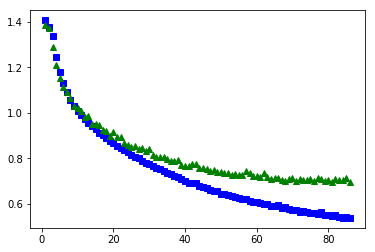

In [26]:
a_epochs = np.arange(1, 1 + len(epoch_train_loss_history))
plt.plot(a_epochs, epoch_train_loss_history, 'bs', a_epochs, epoch_valid_loss_history, 'g^')
plt.show()

### Cálculo da acurácia no conjunto de testes

In [27]:
test_loss = list()
test_image = list()

test_dict = {
    'label': dict(),
    'output': dict()
}
for entry in test_dict:
    for key in ordered_fields:
        test_dict[entry][key] = dict()
        for scale_idx in range(num_scales):
            test_dict[entry][key][scale_idx] = list()

sm = torch.nn.Softmax(dim=0)

test_confidence = dict()
for scale_idx in range(num_scales):
    test_confidence[scale_idx] = list()

with torch.no_grad():
    for i, samples in enumerate(dataset_test):
        # get the inputs
        images = samples[0].unsqueeze(0).to(device)

        labels_reg_list = list()
        labels_cls_list = list()
        for scale_idx in range(num_scales):
            labels_reg_list.append(samples[1][scale_idx].unsqueeze(0))
            labels_cls_list.append(samples[2][scale_idx].unsqueeze(0))

        # forward
        output_list = random_scale_seq_model(images)
        loss = crit(output_list, labels_reg_list, labels_cls_list)

        test_loss.append(loss.cpu().item())
        test_image.append(samples[0].numpy())

        for scale_idx in range(num_scales):
            test_dict['label']['reg'][scale_idx].append(samples[1][scale_idx].numpy())
            test_dict['output']['reg'][scale_idx].append(output_list[scale_idx][0, field_range['start']['reg']:field_range['end']['reg']].cpu().numpy())

            samples_cls_array = samples[2][scale_idx].numpy()
            for key_idx in range(1, len(ordered_fields)):
                key = ordered_fields[key_idx]
                key_index = key_idx - 1

                test_dict['label'][key][scale_idx].append(samples_cls_array[key_index])
                test_dict['output'][key][scale_idx].append(np.argmax(output_list[scale_idx][0, field_range['start'][key]:field_range['end'][key]].cpu().numpy(), axis=0))

            presence_sm = sm(output_list[scale_idx][0, field_range['start']['presence']:field_range['end']['presence']]).cpu().numpy()
            test_confidence[scale_idx].append(presence_sm[1] * test_dict['output']['presence'][scale_idx][-1])

In [28]:
test_loss_array = np.array(test_loss)
test_loss_idx = np.argsort(test_loss_array)

test_image_array = np.concatenate(test_image)

test_array = dict()
for entry in test_dict:
    test_array[entry] = dict()
    for key in ordered_fields:
        test_array[entry][key] = dict()
        for scale_idx in range(num_scales):
            test_array[entry][key][scale_idx] = np.stack(test_dict[entry][key][scale_idx])

for entry in test_dict:
    for scale_idx in range(num_scales):
        test_array[entry]['reg'][scale_idx] *= (digit_size_array[scale_idx] / 2)
        test_array[entry]['number_len'][scale_idx] += 1

test_confidence_array = dict()
for scale_idx in range(num_scales):
    test_confidence_array[scale_idx] = np.stack(test_confidence[scale_idx])

In [29]:
def getResultInfo(arrays_dict, confidence_array, res_idx, digit_size_array, digit_central_ref_array):
    digit_info = {
        'label': list(),
        'output': list()
    }

    digit_idx = {
        'label': 0,
        'output': 0
    }

    for scale_idx in range(num_scales):
        digit_central_ref = digit_central_ref_array[scale_idx]
        confidence_mat = confidence_array[scale_idx][res_idx]

        scale_dict = dict()
        digit_size_mat_dict = dict()
        number_size_mat_dict = dict()
        digit_coord_array_dict = dict()

        for entry in arrays_dict:
            scale_dict[entry] = dict()
            for key in arrays_dict[entry]:
                scale_dict[entry][key] = arrays_dict[entry][key][scale_idx][res_idx]

            digit_size_mat_dict[entry] = digit_size_array[scale_idx] + scale_dict[entry]['delta_height'] * 2
            number_size_mat_dict[entry] = digit_size_mat_dict[entry] * scale_dict[entry]['number_len']
            digit_coord_array_dict[entry] = scale_dict[entry]['presence'].nonzero()

            for digit_coord_idx in range(len(digit_coord_array_dict[entry][0])):
                digit_info_dict = OrderedDict([
                    ('idx', digit_idx[entry])
                ])

                digit_coord_y = digit_coord_array_dict[entry][0][digit_coord_idx]
                digit_coord_x = digit_coord_array_dict[entry][1][digit_coord_idx]

                if entry == 'output':
                    digit_info_dict['confidence'] = confidence_mat[digit_coord_y, digit_coord_x]

                digit_info_dict['digit_class'] = int(scale_dict[entry]['digit_class'][digit_coord_y, digit_coord_x])
                digit_info_dict['digit_index'] = int(scale_dict[entry]['digit_index'][digit_coord_y, digit_coord_x])
                digit_info_dict['number_len'] = int(scale_dict[entry]['number_len'][digit_coord_y, digit_coord_x])

                digit_info_dict['digit_size'] = int(digit_size_mat_dict[entry][digit_coord_y, digit_coord_x])
                delta_size = digit_info_dict['digit_size'] / 2
                digit_info_dict['number_size'] = int(number_size_mat_dict[entry][digit_coord_y, digit_coord_x])

                digit_info_dict['tX'] = scale_dict[entry]['reg'][0][digit_coord_y, digit_coord_x]
                digit_info_dict['tY'] = scale_dict[entry]['reg'][1][digit_coord_y, digit_coord_x]

                digit_info_dict['digit_x'] = (digit_central_ref[digit_coord_x] + digit_info_dict['tX']) - delta_size
                digit_info_dict['digit_y'] = (digit_central_ref[digit_coord_y] + digit_info_dict['tY']) - delta_size
                digit_info_dict['digit_frame'] = np.array([digit_info_dict['digit_x'],
                                                           digit_info_dict['digit_y'],
                                                           digit_info_dict['digit_x']+digit_info_dict['digit_size'],
                                                           digit_info_dict['digit_y']+digit_info_dict['digit_size']])

                digit_0_x = digit_info_dict['digit_x'] - (digit_info_dict['digit_index'] * digit_info_dict['digit_size'])
                digit_info_dict['number_frame'] = np.array([digit_0_x,
                                                            digit_info_dict['digit_y'],
                                                            digit_0_x+digit_info_dict['number_size'],
                                                            digit_info_dict['digit_y']+digit_info_dict['digit_size']])

                digit_info[entry].append(digit_info_dict)
                digit_idx[entry] += 1

    digit_info_range_list = [0, 6, 10, None]

    for entry in digit_info:
        print(entry)
        for info_dict in digit_info[entry]:
            info_dict_map = list(info_dict.items())
            for range_idx in range(len(digit_info_range_list) - 1):
                start_idx = digit_info_range_list[range_idx]
                end_idx = digit_info_range_list[range_idx + 1]

                if range_idx == 0:
                    digit_str = 'Digit '
                else:
                    digit_str = '      '

                digit_str_list = list()
                for key, val in info_dict_map[start_idx:end_idx]:
                    try:
                        if float(val) == int(val):
                            info_str = f'{key}:{val}'
                        else:
                            info_str = f'{key}:{val:5.1f}'
                    except:
                        info_str = f'{key}:{val}'

                    digit_str_list.append(info_str)

                digit_str += ' | '.join(digit_str_list)
                print(digit_str)

        print('\n')

    return digit_info

def vizResult(image_array, idx, digit_info):
    text_fontsize = 14
    bbox_color_dict = {
        'label': {
            'digit': 'green',
            'number': 'blue'
        },
        'output': {
            'digit': 'red',
            'number': 'cyan'
        }
    }

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(image_array[idx], cmap='Greys')
    ax.grid(False)
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')

    for scale_idx in range(num_scales):
        for entry in digit_info:
            for info_dict in digit_info[entry]:
                digit_frame = info_dict['digit_frame']
                digit_size = info_dict['digit_size']
                number_frame = info_dict['number_frame']
                number_size = info_dict['number_size']

                ax.add_patch(patches.Rectangle(digit_frame[:2], digit_size, digit_size,
                                               fill=False, edgecolor=bbox_color_dict[entry]['digit'], lw=2))
                ax.text(digit_frame[0], digit_frame[1] + (text_fontsize//2), str(info_dict['idx']),
                        fontsize=text_fontsize, color=bbox_color_dict[entry]['digit'])

                ax.add_patch(patches.Rectangle(number_frame[:2], number_size, digit_size,
                                               fill=False, edgecolor=bbox_color_dict[entry]['number'], lw=2))
                ax.text(number_frame[0], number_frame[1] + (text_fontsize//2), str(info_dict['idx']),
                        fontsize=text_fontsize, color=bbox_color_dict[entry]['number'])

    plt.show()

In [30]:
def getBBoxMat(number_info):
    bbox_mat_dict = dict()

    for key in ['label', 'output']:
        bbox_mat_dict[key] = np.array([entry['coord'] for entry in number_info[key]])

    return bbox_mat_dict

def non_max_suppression_fast(bb_mat, confs, overlapThresh):
    """
    Adapted from https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    """
    # if there are no boxes, return an empty list
    if len(bb_mat) == 0:
        return []

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = bb_mat[:,0]
    y1 = bb_mat[:,1]
    x2 = bb_mat[:,2]
    y2 = bb_mat[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the highest confidences
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(confs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # Return only the indices of the boxes that survived
    return np.asarray(pick)

### Exemplo com menor perda

label
Digit idx:0 | digit_class:1 | digit_index:0 | number_len:2 | digit_size:50 | number_size:100
      tX:-13.0 | tY:10.0 | digit_x:62.0 | digit_y:5.0
      digit_frame:[ 62.   5. 112.  55.] | number_frame:[ 62.   5. 162.  55.]
Digit idx:1 | digit_class:1 | digit_index:1 | number_len:2 | digit_size:50 | number_size:100
      tX:-3.0 | tY:10.0 | digit_x:112.0 | digit_y:5.0
      digit_frame:[112.   5. 162.  55.] | number_frame:[ 62.   5. 162.  55.]
Digit idx:2 | digit_class:4 | digit_index:0 | number_len:1 | digit_size:48 | number_size:48
      tX:17.0 | tY:5.0 | digit_x:133.0 | digit_y:121.0
      digit_frame:[133. 121. 181. 169.] | number_frame:[133. 121. 181. 169.]
Digit idx:3 | digit_class:6 | digit_index:0 | number_len:1 | digit_size:46 | number_size:46
      tX:-9.0 | tY:-16.0 | digit_x:188.0 | digit_y:101.0
      digit_frame:[188. 101. 234. 147.] | number_frame:[188. 101. 234. 147.]
Digit idx:4 | digit_class:1 | digit_index:0 | number_len:3 | digit_size:40 | number_size:120
   

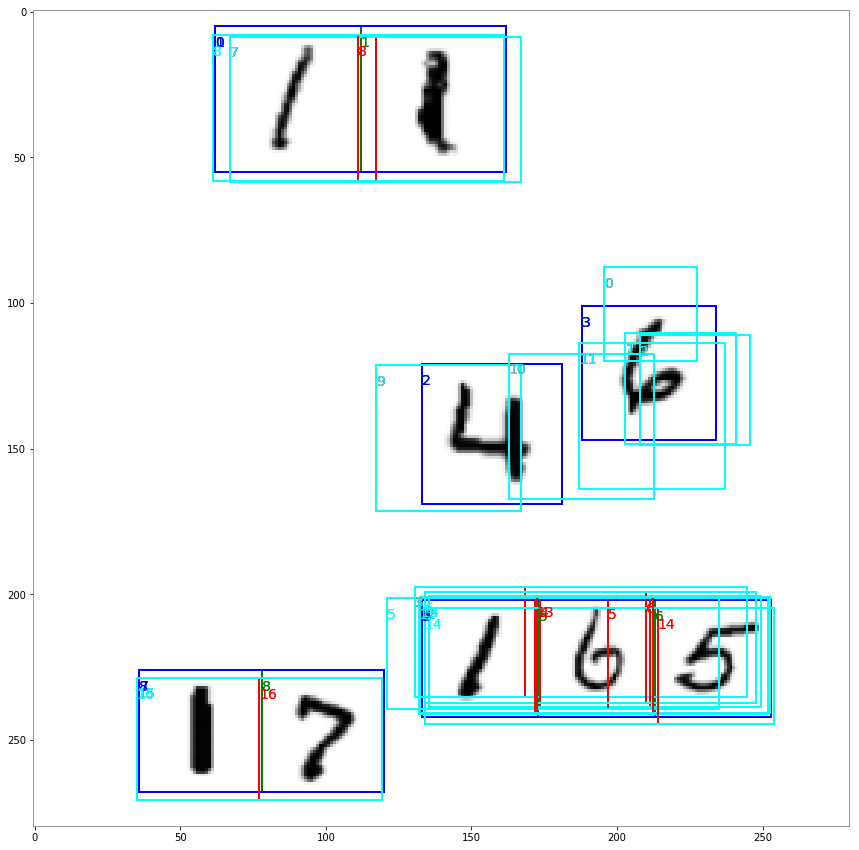

In [31]:
best_digit_info = getResultInfo(test_array, test_confidence, test_loss_idx[0], digit_size_array, digit_central_ref_array)
vizResult(test_image_array, test_loss_idx[0], best_digit_info)

### Exemplo com maior perda

label
Digit idx:0 | digit_class:3 | digit_index:0 | number_len:2 | digit_size:28 | number_size:56
      tX:8.0 | tY:11.0 | digit_x:204.0 | digit_y:11.0
      digit_frame:[204.  11. 232.  39.] | number_frame:[204.  11. 260.  39.]
Digit idx:1 | digit_class:6 | digit_index:1 | number_len:2 | digit_size:28 | number_size:56
      tX:8.0 | tY:11.0 | digit_x:232.0 | digit_y:11.0
      digit_frame:[232.  11. 260.  39.] | number_frame:[204.  11. 260.  39.]
Digit idx:2 | digit_class:3 | digit_index:0 | number_len:1 | digit_size:32 | number_size:32
      tX:10.0 | tY:13.0 | digit_x:64.0 | digit_y:39.0
      digit_frame:[64. 39. 96. 71.] | number_frame:[64. 39. 96. 71.]
Digit idx:3 | digit_class:2 | digit_index:0 | number_len:1 | digit_size:38 | number_size:38
      tX:10.0 | tY:-4.0 | digit_x:117.0 | digit_y:19.0
      digit_frame:[117.  19. 155.  57.] | number_frame:[117.  19. 155.  57.]
Digit idx:4 | digit_class:1 | digit_index:0 | number_len:2 | digit_size:30 | number_size:60
      tX:-12.0 | 

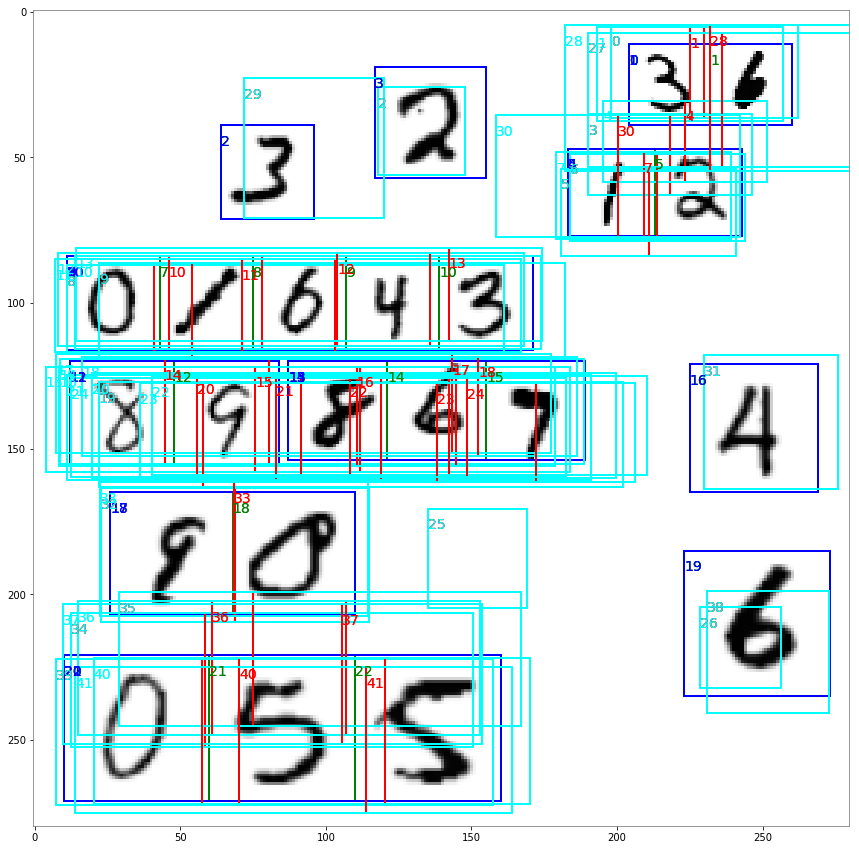

In [32]:
worst_number_info = getResultInfo(test_array, test_confidence, test_loss_idx[-1], digit_size_array, digit_central_ref_array)
vizResult(test_image_array, test_loss_idx[-1], worst_number_info)